In [12]:
# %load https://raw.githubusercontent.com/hassothea/AggregationMethods/main/GradientCOBRARegressor.py

# Import all the libraries 
# ========================
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import RidgeCV, LassoCV, BayesianRidge, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.utils import shuffle
from sklearn.utils.validation import check_X_y
from scipy import spatial, optimize
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# Plotting figures
import matplotlib.pyplot as plt
from matplotlib import cm
# Table type
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator

class GradientCOBRARegressor(BaseEstimator):
    def __init__(self, 
                random_state = None, 
                kernel = 'radial', 
                estimator_list = None,
                show_progress = True, 
                estimator_params = None, 
                optimize_method = "grid", 
                optimize_params = None,
                kernel_params = None):
        """
        This is a class of the implementation of the Kernel-based consensual aggregation method for regression by Has (2023).


        * Parameters:
        ------------
        - random_state: (default is `None`) set the random state of the random generators in the class.
        kernel: (default is 'radial') the name of kernel function to be used for the aggregation. 
            It should be an element of the list ['exponential', 'gaussian', 'radial', 'epanechnikov', 'biweight', 'triweight', 'triangular', 'cobra', 'naive'].
            Some options such as 'gaussian' and 'radial' lead to the same gaussian kernel function. Same for 'cobra' and 'naive', corresponds to Biau et al. (2016).
        
        - estimator_list: (default is None) the list of intial estimators (machines). If None, intial estimators 'knn', 'ridge', 'lasso', 'tree', 'random_forest' and 'svm' are used.
            It should be a sublist of the following list: ['knn', 'ridge', 'lasso', 'tree', 'random_forest' and 'svm', 'sgd', 'bayesian_ridge', 'adaboost', 'gradient_boost'].
        
        - show_progress: (default is `True`) boolean defining whether or not to show the progress of the optimization algorithm.
        
        - estimator_params: (default is `None`) a dictionary of parameters of the basic estimators given in the `estimator_list` argument. It should be a dictionary containing the names of the basic estimators, 
            which is also a dictionary of the names of its paremters.
        
        - optimize_method: (default is "grid") optimization algorithm for learning the bandwidth parameter. It should be either "grid" (grid search) or "grad" (gradient descent for non-compactly supported kernel such as radial kernel).
        
        - optimize_params: a dictionary of parameters of the optimization algorithm (both grid and grad). Its should be dictionary of the following elements:
            - 'bandwidth_list' : bandwidth grid for grid search algorithm
            - 'epsilon' : threshold to stop the gradient descent algorithm
            - 'learning_rate' : learning rate for grad algorithm
            - 'speed' : speed of the learning rate,
            - 'n_tries' : the number of tries for the initial step of the grad algorithm,
            - 'start' : the initial value of the bandwidth parameter
            - 'max_iter' : maximum iteration of gradient descent algorithm
            - 'n_cv' : number of cross-validation folds.

        * Returns:
        ---------
        self : returns an instance of self. 

        * Methods: 
        ---------
        - fit : fitting the aggregation method on the design features (original data or predicted features).
        - split_data : split the data into D_k = {(X_k,y_k)} and D_l = {(X_l,y_l)} to construct the estimators and perform aggregation respectively.
        - build_basic_estimators : build basic estimators for the aggregation. It is also possible to set the values of (hyper) parameters for each estimators.
        - load_predictions : to make predictions using constructed basic estimators.
        - distances : construct distance matrix according to the kernel function used in the aggregation.
        - kappa_cross_validation_error : the objective function to be minimized.
        - optimize_bandwidth : the optimization method to estimate the optimal bendwidth parameter.
        - predict : for building prediction on the new observations using any given bendwidth or the estimated one.
        - plot_learning_curve : for plotting the graphic of learning algorithm (error vs parameter).

        """
        opt_param = {'bandwidth_list' : np.linspace(0.00001, 100, 300),
                     'epsilon' : 10 ** (-10),
                     'learning_rate' : 0.1,
                     'speed' : 'constant',
                     'n_tries' : int(5),
                     'start' : None,
                     'max_iter' : 50,
                    'n_cv' : int(5)}
        
        kernel_param = {
            'alpha' : 2.0,
            'sigma' : 1.0,
            'precision' : 10 ** (-5)
        }
        if optimize_params is not None:
            for obj in optimize_params:
                opt_param[obj] = optimize_params[obj]
        if kernel_params is not None:
            for obj in kernel_params:
                kernel_param[obj] = kernel_params[obj]
        if kernel not in ['radial', 'gaussian', 'exponential', 'reverse_cosh']:
            optimize_method = 'grid'
        
        self.random_state = random_state
        self.kernel = kernel
        self.estimator_list = estimator_list
        self.show_progress = show_progress
        self.estimator_params = estimator_params
        self.optimize_method = optimize_method
        self.optimize_params = opt_param
        self.kernel_params = kernel_param

        list_kernels = {
            'reverse_cosh' : lambda x,y: 1/np.cosh(-x*(y/self.kernel_params['sigma'])),
            'exponential' : lambda x,y: np.exp(-y*(x/self.kernel_params['sigma']) ** self.kernel_params['alpha']),
            'gaussian' : lambda x,y: np.exp(-x*y/self.kernel_params['sigma']),
            'radial' : lambda x,y: np.exp(-x*y/self.kernel_params['sigma']),
            'epanechnikov' : lambda x,y: (1 - x*y/self.kernel_params['sigma']) * (x*y/self.kernel_params['sigma'] < 1),
            'biweight' : lambda x,y: (1-x*y/self.kernel_params['sigma']) ** 2 * (x*y/self.kernel_params['sigma'] < 1),
            'triweight' : lambda x,y: (1-x*y/self.kernel_params['sigma']) ** 3 * (x*y/self.kernel_params['sigma'] < 1),
            'triangular' : lambda x,y: (1-np.abs(x*y/self.kernel_params['sigma'])) * (x*y/self.kernel_params['sigma'] < 1),
            'cobra' : lambda x,y: np.array(x*y/self.kernel_params['sigma']),
            'naive' : lambda x,y: np.array(x*y/self.kernel_params['sigma']),
            'cauchy' : lambda x,y: 1/(1 + np.array(x*y/self.kernel_params['sigma']))
        }
        self.list_kernels = list_kernels

    def fit(self, X, y, split = .5, overlap = 0, X_k = None, y_k = None, X_l = None, y_l = None, as_predictions = False):
        X_ = X.copy()
        if not isinstance(X, pd.core.frame.DataFrame):
            X_ = pd.DataFrame(X)
        self.X_ = X_
        self.y_ = y
        self.X_k_ = X_k
        self.X_l_ = X_l
        self.y_k_ = y_k
        self.y_l_ = y_l
        self.as_predictions = as_predictions
        self.basic_estimtors = {}
        if not as_predictions:
            self.split_data(split = split, overlap=overlap)
            self.build_baisc_estimators()
            self.load_predictions()
            self.optimize_bandwidth(params = self.optimize_params)
        else:
            self.pred_X_l = pd.DataFrame(X)
            self.estimator_names = X.dtype.names
            self.number_estimators = X.shape[1]
            self.X_l_ = pd.DataFrame(X)
            self.y_l_ = y
            self.optimize_bandwidth(params = self.optimize_params)
        return self
    
    def split_data(self, split, overlap, k = None, shuffle_data = True):
        if shuffle_data:
            self.X_, self.y_ = shuffle(self.X_, self.y_, random_state = self.random_state)
        if k is None:
            k1 = int(len(self.y_) * (split-overlap/2))
            k2 = int(len(self.y_) * (split+overlap/2))
        self.X_k_ = self.X_.iloc[:k2,:]
        self.X_l_ = self.X_.iloc[k1:,:]
        self.y_k_ = self.y_[:k2]
        self.y_l_ = self.y_[k1:]
        return self

    def build_baisc_estimators(self):
        all_estimators = {
            'extra_trees' : ExtraTreesRegressor(random_state=self.random_state),
            'knn' : KNeighborsRegressor(),
            'lasso' : LassoCV(),
            'ridge' : RidgeCV(),
            'tree' : DecisionTreeRegressor(random_state=self.random_state),
            'random_forest' : RandomForestRegressor(random_state=self.random_state),
            'svm' : SVR(),
            'bayesian_ridge' : BayesianRidge(),
            'sgd' : SGDRegressor(random_state=self.random_state),
            'adaboost' : AdaBoostRegressor(random_state=self.random_state),
            'gradient_boost' : GradientBoostingRegressor(random_state=self.random_state)
        }
        estimator_dict = {}
        if self.estimator_list == "all":
            estimator_dict = all_estimators
        elif self.estimator_list is None:
            estimator_dict = {'knn' : KNeighborsRegressor(),
                              'lasso' : LassoCV(),
                              'ridge' : RidgeCV(),
                              'tree' : DecisionTreeRegressor(random_state=self.random_state),
                              'random_forest' : RandomForestRegressor(random_state=self.random_state),
                              'extra_trees' : ExtraTreesRegressor(random_state=self.random_state),
                              'svm' : SVR()}
        else:
            for name in self.estimator_list:
                estimator_dict[name] = all_estimators[name]
        self.estimator_names = list(estimator_dict.keys())
        param_dict = {
            'knn' : None,
            'lasso' : None,
            'ridge' : None,
            'tree' : None,
            'random_forest' : None,
            'svm' : None,
            'bayesian_ridge' : None,
            'sgd' : None,
            'adaboost' : None,
            'gradient_boost' : None,
            'extra_trees' : None
        }
        self.basic_estimators = {}
        if self.estimator_params is not None:
            for name in list(self.estimator_params):
                param_dict[name] = self.estimator_params[name]
        for machine in self.estimator_names:
            try:
                mod = estimator_dict[machine]
                if param_dict[machine] is not None:
                    if machine == 'adaboost':
                        mod.estimator = DecisionTreeRegressor()
                        param_ = {}
                        for p_ in mod.estimator.get_params():
                            if p_ in list(param_dict[machine].keys()):
                                param_[p_] = param_dict[machine][p_]
                                param_dict[machine].pop(p_)
                        mod.estimator.set_params(**param_)
                        mod.set_params(**param_dict[machine])
                    else:
                        mod.set_params(**param_dict[machine])
            except ValueError:
                continue
            self.basic_estimators[machine] = mod.fit(self.X_k_, self.y_k_)
        return self

    def load_predictions(self):
        self.pred_features = {}
        for machine in self.estimator_names:
            self.pred_features[machine] = self.basic_estimators[machine].predict(self.X_l_)
        self.pred_X_l = pd.DataFrame(self.pred_features)
        self.number_estimators = len(self.estimator_names)
        return self
    
    def distances(self, x, pred_test = None, p = 2):
        if pred_test is None:
            ids = pd.DataFrame({'shuffle': list(range(self.optimize_params['n_cv']))})
            self.index_shuffled = ids.sample(x.shape[0], replace=True).shuffle.values
            if p != 0:
                self.distance_matrix = spatial.distance_matrix(x,x,p) ** 2
            else:
                dis = np.ndarray(shape=(x.shape[0], x.shape[0]))
                for i in range(x.shape[0]):
                    dis[i,:] = [spatial.distance.hamming(x[i,:], x[j,:]) for j in range(x.shape[0])]
                self.distance_matrix = dis
        else:
            if p != 0:
                self.distance_matrix_test = spatial.distance_matrix(x,pred_test,p) ** 2
            else:
                dis = np.ndarray(shape=(x.shape[0], pred_test.shape[0]))
                for i in range(x.shape[0]):
                    dis[i,:] = [spatial.distance.hamming(x[i,:], pred_test[j,:]) for j in range(pred_test.shape[0])]
                self.distance_matrix_test = dis

    # def distances(self, pred_k = None, pred_l = None, distance = None, fold = None):
    #     lk = pred_k.shape
    #     ll = pred_l.shape
    #     D = np.full(shape = (lk[0], ll[0]), fill_value = np.float64)
    #     if distance in [None, "l2"]:
    #         for i in range(lk[0]):
    #             D[i,:] = (np.subtract(np.array(pred_k.iloc[i,:]), pred_l) ** 2).sum(axis = 1)
    #     if distance in ["l1"]:
    #         for i in range(lk[0]):
    #             D[i,:] = np.abs(np.subtract(np.array(pred_k.iloc[i,:]), pred_l)).sum(axis = 1)
    #     if distance in ["naive"]:
    #         for i in range(lk[0]):
    #             D[i,:] = [spatial.distance.hamming(np.array(pred_k.iloc[i,:]), pred_l.iloc[j,:]) for j in range(ll[0])]
    #     if fold is None:
    #         self.distance_matrix[distance] = D
    #     else:
    #         self.distance_matrix[distance+str(fold)] = D
    #     return self
    
    def kappa_cross_validation_error(self, bandwidth = 1):
        list_kernels = self.list_kernels
        if self.kernel in ['cobra', 'naive']:
            cost = np.full((self.optimize_params['n_cv'], self.number_estimators+1), fill_value = np.float64)
            for m in range(self.number_estimators+1):
                for i in range(self.optimize_params['n_cv']):
                    D_k = (list_kernels[self.kernel](self.distance_matrix[self.index_shuffled != i,:][:,self.index_shuffled == i], bandwidth) <= m/self.number_estimators)
                    D_k_ = np.sum(D_k, axis=0, dtype=np.float64)
                    D_k_[D_k_ == 0] = np.Inf
                    res = np.matmul(self.y_l_[self.index_shuffled != i], D_k)/D_k_
                    cost[i,self.number_estimators-m] = mean_squared_error(res, self.y_l_[self.index_shuffled == i])
            cost_ = cost.mean(axis=0)
        else:
            cost = np.full(self.optimize_params['n_cv'], fill_value = np.float64)
            for i in range(self.optimize_params['n_cv']):
                D_k = list_kernels[self.kernel](self.distance_matrix[self.index_shuffled != i,:][:,self.index_shuffled == i], bandwidth)
                D_k_ = np.sum(D_k, axis=0, dtype=np.float64)
                D_k_[D_k_ == 0] = np.Inf
                res = np.matmul(self.y_l_[self.index_shuffled != i], D_k)/D_k_
                cost[i] = mean_squared_error(res, self.y_l_[self.index_shuffled == i])
            cost_ = cost.mean()
        return cost_
        
    def optimize_bandwidth(self, params):
        def select_best_index(arr):
            l, c = arr.shape
            if l > 1:
                return arr[l//2,]
            else:
                return arr
            
        def gradient(f, x0, eps = self.kernel_params['precision']):
            return np.array([(f(x0+eps) - f(x0-eps))/(2*eps)])

        kernel_to_dist = {'naive' : 'naive',
                          'cobra' : 'naive',
                          '0-1' : 'naive',
                          'reverse_cosh' : 'l2',
                          'uniform' : 'naive',
                          'exponential' : 'l2',
                          'gaussian' : 'l2',
                          'normal' : 'l2',
                          'radial' : 'l2',
                          'epanechnikov' : 'l2',
                          'biweight' : 'l2',
                          'triweight' : 'l2',
                          'triangular' : 'l1',
                          'triang' : 'l1',
                          'cauchy' : 'l2'}
        self.distance_matrix = {}
        self.index_each_fold = {}
        self.distance = kernel_to_dist[self.kernel]
        if self.distance in ['l2', None]:
            self.p_ = 2
        elif self.distance in ['l1']:
            self.p_ = 1
        else:
            self.p_ = 0
        self.distances(self.pred_X_l, p = self.p_)
        if self.optimize_method in ['grid', 'grid_search', 'grid search']:
            n_iter = len(params['bandwidth_list'])
            if self.kernel in ['cobra', 'naive']:
                errors = np.full((n_iter, self.number_estimators+1), np.float64)
                if self.show_progress:
                    print('\n\t-> Grid search algorithm with '+ str(self.kernel) + ' kernel is in progress...')
                    print('\t\t~ Full process|--------------------------------------------------|100%')
                    print('\t\t~   Processing|', end ='')
                    m = 1
                    count = 0
                    if n_iter <= 50:
                        n_ = n_iter
                    else:
                        n_ = 50
                    cut = n_iter // n_
                    for iter in range(n_iter):
                        if iter == m * cut:
                            print("=", end = '')
                            if m == 49:
                                print("=|100%")
                            m += 1
                        count += 1
                        errors[iter,:] = self.kappa_cross_validation_error(bandwidth=params['bandwidth_list'][iter])
                else:
                    for iter in range(n_iter):
                        errors[iter,:] = self.kappa_cross_validation_error(bandwidth=params['bandwidth_list'][iter])
                opt_risk = np.min(np.min(errors))
                opt_id = select_best_index(np.array(np.where(errors == opt_risk)))
                self.optimize_outputs = {
                    'number_retained_estimators' : self.number_estimators-opt_id[1],
                    'opt_method' : 'grid',
                    'opt_bandwidth' : self.optimize_params['bandwidth_list'][opt_id[0]],
                    'opt_index': opt_id[0],
                    'kappa_cv_errors': errors
                }
            else:
                errors = np.full(n_iter, np.float64)
                if self.show_progress:
                    print('\n\t-> Grid search algorithm with '+ str(self.kernel) + ' kernel is in progress...')
                    print('\t\t~ Full process|--------------------------------------------------|100%')
                    print('\t\t~   Processing|', end ='')
                    m = 1
                    count = 0
                    if n_iter <= 50:
                        n_ = n_iter
                    else:
                        n_ = 50
                    cut = n_iter // n_
                    for iter in range(n_iter):
                        if iter == m * cut:
                            print("=", end = '')
                            if m == 49:
                                print("=|100%")
                            m += 1
                        count += 1
                        errors[iter] = self.kappa_cross_validation_error(bandwidth=params['bandwidth_list'][iter])
                else:
                    for iter in range(n_iter):
                        errors[iter] = self.kappa_cross_validation_error(bandwidth=params['bandwidth_list'][iter])
                opt_risk = np.min(np.min(errors))
                opt_id = select_best_index(np.array(np.where(errors == opt_risk)).reshape((-1,1)))
                self.optimize_outputs = {
                    'opt_method' : 'grid',
                    'opt_bandwidth' : self.optimize_params['bandwidth_list'][opt_id[0]],
                    'opt_index': opt_id[0],
                    'kappa_cv_errors': errors
                }
        if self.optimize_method in ['grad', 'gradient descent', 'gd', 'GD']:
            n_iter = len(params['bandwidth_list'])
            errors = np.full(n_iter, float)
            collect_bw = []
            gradients = []
            speed_list = {
                'constant' : lambda x, y: y,
                'linear' : lambda x, y: x*y,
                'log' : lambda x, y: np.log(1+x) * y,
                'root' : lambda x, y: np.sqrt(1+x) * y,
                'sqrt' : lambda x, y: (1+x ** 2) * y,
                'exp' : lambda x, y: np.exp(x) * y
            }
            if self.optimize_params['start'] is None:
                bws = np.linspace(0.0001, 1/np.var(self.y_l_), num = self.optimize_params['n_tries'])
                initial_tries = [self.kappa_cross_validation_error(bandwidth=b) for b in bws]
                bw0 = bws[np.argmin(initial_tries)]
            else:
                bw0 = self.optimize_params['start']
            grad = gradient(self.kappa_cross_validation_error, bw0, self.kernel_params['precision'])
            if self.show_progress:
                print('\n\t* Gradient descent with '+ str(self.kernel) + ' kernel is implemented...')
                print('\t\t~ Initial t = 0:    \t~ bandwidth: %.3f \t~ gradient: %.3f \t~ threshold: ' %(bw0, grad[0]), end = '')
                print(str(self.optimize_params['epsilon']))
                r0 = self.optimize_params['learning_rate'] / abs(grad)        # make the first step exactly equal to `learning-rate`.
                rate = speed_list[self.optimize_params['speed']]              # the learning rate can be varied, and speed defines this change in learning rate.
                count = 0
                grad0 = grad
                while count < self.optimize_params['max_iter']:
                    bw = bw0 - rate(count, r0) * grad
                    if bw < 0 or np.isnan(bw):
                        bw = bw / 1.25
                    if count > 3:
                        if np.sign(grad)*np.sign(grad0) < 0:
                            r0 = r0 / 1.25
                        if test_threshold > self.optimize_params['epsilon']:
                            bw0, grad0 = bw, grad
                        else:
                            break
                    relative = abs((bw - bw0) / bw0)
                    test_threshold = np.mean([relative, abs(grad)])
                    grad = gradient(self.kappa_cross_validation_error, bw0, self.kernel_params['precision'])
                    count += 1
                    print('\t\t~     Iteration: %d \t~ epsilon: %.3f \t~ gradient: %.3f \t~ stopping criterion: %.3f' % (count, bw[0], grad[0], test_threshold), end="\r")
                    collect_bw.append(bw[0])
                    gradients.append(grad[0])
                print("                                                                                                                                                                            ", end = '\r')
                print('\t\t~    Stopped at: %d \t~ epsilon: %.3f \t~ gradient: %.3f \t~ stopping criterion: %.3f' % (count, bw[0], grad[0], test_threshold))
            else:
                r0 = self.optimize_params['learning_rate'] / abs(grad)
                rate = speed_list[self.optimize_params['speed']]
                count = 0
                grad0 = grad
                while count < self.optimize_params['max_iter']:
                    bw = bw0 - rate(count, r0) * grad
                    if bw < 0 or np.isnan(bw):
                        bw = bw / 1.25
                    if count > 3:
                        if np.sign(grad)*np.sign(grad0) < 0:
                            r0 = r0 / 1.25
                        if test_threshold > self.optimize_params['epsilon']:
                            bw0, grad0 = bw, grad
                        else:
                            break
                    relative = abs((bw - bw0) / bw0)
                    test_threshold = np.mean([relative, abs(grad)])
                    grad = gradient(self.kappa_cross_validation_error, bw0, self.kernel_params['precision'])
                    count += 1
                    collect_bw.append(bw[0])
                    gradients.append(grad[0])
            opt_bw = bw[0]
            opt_risk = self.kappa_cross_validation_error(opt_bw)
            self.optimize_outputs = {
                'opt_method' : 'grad',
                'opt_bandwidth' : opt_bw,
                'bandwidth_collection' : collect_bw,
                'gradients': gradients
                #'kappa_cv_errors': np.array([self.kappa_cross_validation_error(b) for b in collect_bw])
            }
        return self

    def predict(self, X, bandwidth = None):
        if bandwidth is None:
            bandwidth = self.optimize_outputs['opt_bandwidth']
        if self.as_predictions:
            self.pred_features_test = X
        else: 
            self.pred_features_test = {}
            for machine in self.estimator_names:
                self.pred_features_test[machine] = self.basic_estimators[machine].predict(X)
        self.pred_features_x_test = pd.DataFrame(self.pred_features_test, columns=self.estimator_names)
        self.distances(x = self.pred_X_l, pred_test = self.pred_features_x_test, p = self.p_)
        if self.kernel in ['cobra', 'naive']:
            D_k = (self.list_kernels[self.kernel](np.float64(self.distance_matrix_test), bandwidth) <= (self.optimize_outputs['number_retained_estimators'])/self.number_estimators)
            
        else:
            D_k = self.list_kernels[self.kernel](self.distance_matrix_test, bandwidth)
        D_k_ = np.sum(D_k, axis=0, dtype=np.float64)
        D_k_[D_k_ == 0] = np.Inf
        res = np.matmul(self.y_l_, D_k)/D_k_
        res[res == 0] = res[res != 0].mean()
        self.test_prediction = res
        return res
        
    def plot_learning_curve(self, y_test = None,  fig_type = 'qq', save_fig = False, fig_path = None, dpi = None, show_fig = True):
        if (y_test is not None) and (fig_type in ['qq', 'qq-plot', 'qqplot', 'QQ-plot', 'QQplot']):
            fig = plt.figure(figsize=(7, 3))
            plt.plot(y_test, y_test, 'r')
            plt.scatter(y_test, self.test_prediction)
            plt.xlabel('y_test')
            plt.ylabel('prediction')
            plt.title('QQ-plot: actual Vs prediction')
            plt.legend()
            if save_fig:
                if dpi is None:
                    dpi = 800
                    if fig_path is not None:
                        plt.savefig("qqplot_aggregation.png", format = 'png', dpi=dpi, bbox_inches='tight')
                    else:
                        plt.savefig(fig_path, format = 'png', dpi=dpi, bbox_inches='tight')
            if show_fig:
                plt.show()
        else:
            if self.optimize_outputs['opt_method'] == 'grid':
                if self.kernel in ['naive', 'cobra']:
                    num_estimators, bandwidths = np.meshgrid(list(range(0,self.number_estimators+1,1)), self.optimize_params['bandwidth_list'])
                    err = self.optimize_outputs['kappa_cv_errors']
                    num_opt = self.optimize_outputs['number_retained_estimators']
                    band_opt = self.optimize_outputs['opt_bandwidth']
                    fig = plt.figure(figsize=(10,6))
                    axs = fig.add_subplot(projection='3d')
                    surf = axs.plot_surface(bandwidths, num_estimators, err, cmap=cm.coolwarm, linewidth=0, antialiased=False)
                    axs.plot(band_opt, num_opt, self.optimize_outputs['kappa_cv_errors'][self.optimize_outputs['opt_index'], num_opt], 'o')
                    axs.set_title("Errors Vs bandwidths and number of estimators ("+ str(self.kernel)+ " kernel)")
                    axs.set_xlabel("bandwidth")
                    axs.set_ylabel("number of estimators")
                    axs.set_zlabel("Kappa cross-validation error")
                    axs.view_init(30, 60)
                    if save_fig:
                        if dpi is None:
                            dpi = 800
                        if fig_path is None:
                            plt.savefig("fig_learning_surface.png", format = 'png', dpi=dpi, bbox_inches='tight')
                        else:
                            plt.savefig(fig_path, format = 'png', dpi=dpi, bbox_inches='tight')
                    if show_fig:
                        plt.show()
                else:
                    plt.figure(figsize=(7, 3))
                    plt.plot(self.optimize_params['bandwidth_list'], self.optimize_outputs['kappa_cv_errors'])
                    plt.title('Errors Vs bandwidths (grid search)')
                    plt.xlabel('bandwidth')
                    plt.ylabel('error')
                    plt.scatter(self.optimize_outputs['opt_bandwidth'], self.optimize_outputs['kappa_cv_errors'][self.optimize_outputs['opt_index']], c = 'r')
                    plt.vlines(x=self.optimize_outputs['opt_bandwidth'], ymin=self.optimize_outputs['kappa_cv_errors'][self.optimize_outputs['opt_index']]/5, ymax=self.optimize_outputs['kappa_cv_errors'][self.optimize_outputs['opt_index']], colors='r', linestyles='--')
                    plt.hlines(y=self.optimize_outputs['kappa_cv_errors'][self.optimize_outputs['opt_index']], xmin=0, xmax=self.optimize_outputs['opt_bandwidth'], colors='r', linestyles='--')
                    if save_fig:
                        if dpi is None:
                            dpi = 800
                        if fig_path is None:
                            plt.savefig("fig_learning_curve.png", format = 'png', dpi=dpi, bbox_inches='tight')
                        else:
                            plt.savefig(fig_path, format = 'png', dpi=dpi, bbox_inches='tight')
                    if show_fig:
                        plt.show()
            else:
                fig = plt.figure(figsize=(10, 3))
                ax1 = fig.add_subplot(1,2,1)
                ax1.plot(range(len(self.optimize_outputs['bandwidth_collection'])), self.optimize_outputs['bandwidth_collection'])
                ax1.hlines(y=self.optimize_outputs['bandwidth_collection'][-1], xmin=0, xmax=self.optimize_params['max_iter'], colors='r', linestyles='--')
                ax1.set_title('Bandwidths at each iteration (gradient descent)')
                ax1.set_xlabel('iteration')
                ax1.set_ylabel('bandwidth')
                
                ax2 = fig.add_subplot(1,2,2)
                param_range = np.linspace(self.optimize_outputs['opt_bandwidth']/5, self.optimize_outputs['opt_bandwidth']*5, 20)
                errors = [self.kappa_cross_validation_error(b) for b in param_range] 
                opt_error = self.kappa_cross_validation_error(self.optimize_outputs['opt_bandwidth']) 
                ax2.plot(param_range, errors)
                ax2.set_title('Errors Vs bandwidths')
                ax2.set_xlabel('bandwidth')
                ax2.set_ylabel('error')
                ax2.scatter(self.optimize_outputs['opt_bandwidth'], opt_error, c = 'r')
                ax2.vlines(x=self.optimize_outputs['opt_bandwidth'], ymin=opt_error/5, ymax=opt_error, colors='r', linestyles='--')
                ax2.hlines(y=opt_error, xmin=0, xmax=self.optimize_outputs['opt_bandwidth'], colors='r', linestyles='--')
                if save_fig:
                    if dpi is None:
                        dpi = 800
                    if fig_path is None:
                        plt.savefig("fig_learning_curve.png", format = 'png', dpi=dpi, bbox_inches='tight')
                    else:
                        plt.savefig(fig_path, format = 'png', dpi=dpi, bbox_inches='tight')
                if show_fig:
                    plt.show()


# 1. Simulated example

In [2]:
# Simulated dataset
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=1000, n_features=3, noise=0.1)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('shape: x_train = {} , x_train = {} , y_train = {} , y_test = {}'.format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))

shape: x_train = (16512, 8) , x_train = (4128, 8) , y_train = (16512,) , y_test = (4128,)


In [14]:
# Train aggregation method using Gradient descent without setting parameter of basic predictors

agg = GradientCOBRARegressor(kernel='radial',
                             optimize_method='grad',
                             optimize_params={
                                 'learning_rate' : 0.001,
                                 'max_iter' : 500,
                                 'speed' : 'linear'
                             })
agg.fit(X_train, y_train)


	* Gradient descent with radial kernel is implemented...
		~ Initial t = 0:    	~ bandwidth: 0.000 	~ gradient: -1482831.832 	~ threshold: 1e-10
		~    Stopped at: 169 	~ epsilon: 0.002 	~ gradient: 0.000 	~ stopping criterion: 0.000                                                                                    


GradientCOBRARegressor(kernel_params={'alpha': 2.0, 'precision': 1e-05,
                                      'sigma': 1.0},
                       optimize_method='grad',
                       optimize_params={'bandwidth_list': array([1.00000000e-05, 3.34458127e-01, 6.68906254e-01, 1.00335438e+00,
       1.33780251e+00, 1.67225064e+00, 2.00669876e+00, 2.34114689e+00,
       2.67559502e+00, 3.01004314e+00, 3.34449127e+00, 3.67893940e+00,
       4.01338753e+00, 4.34783565...
       9.36454856e+01, 9.39799337e+01, 9.43143818e+01, 9.46488300e+01,
       9.49832781e+01, 9.53177262e+01, 9.56521743e+01, 9.59866225e+01,
       9.63210706e+01, 9.66555187e+01, 9.69899669e+01, 9.73244150e+01,
       9.76588631e+01, 9.79933112e+01, 9.83277594e+01, 9.86622075e+01,
       9.89966556e+01, 9.93311037e+01, 9.96655519e+01, 1.00000000e+02]),
                                        'epsilon': 1e-10,
                                        'learning_rate': 0.001, 'max_iter': 500,
                                        'n_cv': 5, 'n_tries': 5,
                                        'speed': 'linear', 'start': None})

In [15]:
print("Optimal bandwidth: {}".format(agg.optimize_outputs['opt_bandwidth']))

Optimal bandwidth: 0.0020992518791021573


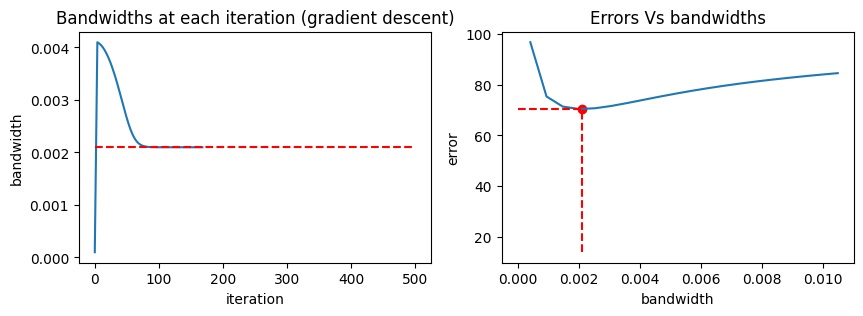

In [16]:
# Plot graphic of learning algorithm

agg.plot_learning_curve()

In [17]:
from sklearn.metrics import mean_absolute_percentage_error
y_pred = agg.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)

0.20032469181689266

Text(0, 0.5, 'prediction')

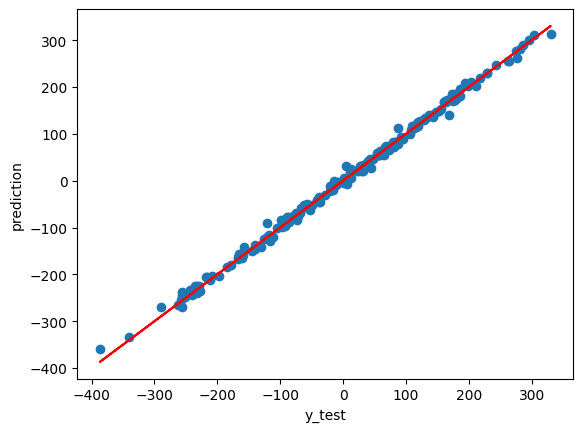

In [18]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.plot(y_test, y_test, c = 'red')
plt.xlabel('y_test')
plt.ylabel('prediction')

## We can improve this result by choosing other basic regressors. It is also possible to set parameters and hyperparameters of each individual estimator.

In [19]:
agg1 = GradientCOBRARegressor(kernel='radial',
                             optimize_method='grad',
                             optimize_params={
                                 'learning_rate' : 0.01,
                                 'max_iter' : 300,
                                 'speed' : 'linear'
                             },
                             estimator_list=['random_forest', 'adaboost', 'knn', 'svm', 'lasso', 'ridge'],
                             estimator_params={
                                'random_forest' : {'n_estimators' : 300,
                                                   'min_samples_leaf' : 10},
                                'adaboost' : {
                                    'n_estimators' : 300,
                                    'max_depth' : 10
                                },
                                'knn' : {'n_neighbors' : 30},
                                'svm' : {'C' : 7}
                             })

agg1.fit(X_train, y_train)


	* Gradient descent with radial kernel is implemented...
		~ Initial t = 0:    	~ bandwidth: 0.000 	~ gradient: -2316189.440 	~ threshold: 1e-10
		~    Stopped at: 118 	~ epsilon: 0.001 	~ gradient: 0.000 	~ stopping criterion: 0.000                                                                                    


GradientCOBRARegressor(estimator_list=['random_forest', 'adaboost', 'knn',
                                       'svm', 'lasso', 'ridge'],
                       estimator_params={'adaboost': {'n_estimators': 300},
                                         'knn': {'n_neighbors': 30},
                                         'random_forest': {'min_samples_leaf': 10,
                                                           'n_estimators': 300},
                                         'svm': {'C': 7}},
                       kernel_params={'alpha': 2.0, 'precision': 1e-05,
                                      'sigma': 1.0},
                       optimize_method='grad',
                       optimize_params={'bandwid...
       9.36454856e+01, 9.39799337e+01, 9.43143818e+01, 9.46488300e+01,
       9.49832781e+01, 9.53177262e+01, 9.56521743e+01, 9.59866225e+01,
       9.63210706e+01, 9.66555187e+01, 9.69899669e+01, 9.73244150e+01,
       9.76588631e+01, 9.79933112e+01, 9.83277594e+01, 9.86622075e+01,
       9.89966556e+01, 9.93311037e+01, 9.96655519e+01, 1.00000000e+02]),
                                        'epsilon': 1e-10,
                                        'learning_rate': 0.001, 'max_iter': 300,
                                        'n_cv': 5, 'n_tries': 5,
                                        'speed': 'linear', 'start': None})

In [20]:
print("Optimal bandwidth: {}".format(agg1.optimize_outputs['opt_bandwidth']))

Optimal bandwidth: 0.001166546571012846


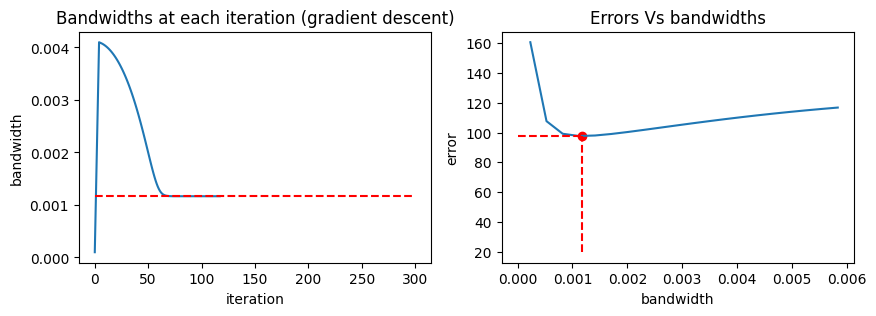

In [21]:
# Plot graphic of learning algorithm

agg1.plot_learning_curve()

In [22]:
y_pred1 = agg1.predict(X_test)
print(mean_absolute_percentage_error(y_test, y_pred1))
print(mean_squared_error(y_test, y_pred1))

0.10839728501088595

Text(0, 0.5, 'prediction')

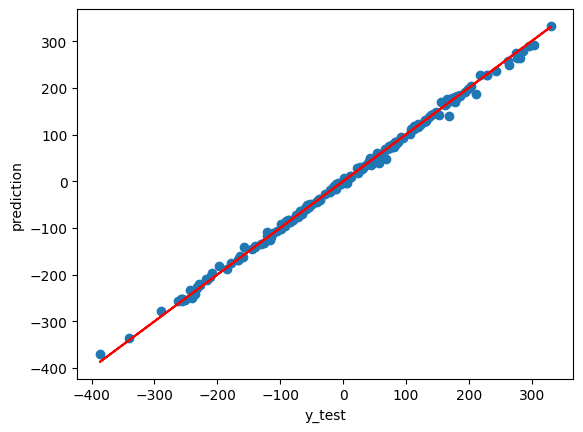

In [23]:
plt.clf()

plt.scatter(y_test, y_pred1)
plt.plot(y_test, y_test, c = 'red')
plt.xlabel('y_test')
plt.ylabel('prediction')

# Real Dataset

In [2]:
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()

In [38]:
X, y = data['data'], data['target']

In [62]:
# For 1000 observations
X_train2, X_test2, y_train2, y_test2 = train_test_split(X[:1000,:], y[:1000], test_size=0.2)
print('shape: x_train = {} , x_train = {} , y_train = {} , y_test = {}'.format(X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape))

shape: x_train = (800, 8) , x_train = (200, 8) , y_train = (800,) , y_test = (200,)


In [63]:
agg2 = GradientCOBRARegressor(optimize_method="grad",
                              estimator_list=['random_forest', 'adaboost', 'knn', 'ridge'],
                              optimize_params={
                                  'learning_rate' : 3,
                                  'speed' : 'linear'
                              },
                              estimator_params={
                                  'adaboost' : {'n_estimators' : 300},
                                  'random_forest' : {'n_estimators': 300},
                                  'knn' : {'n_neighbors' : 300}
                              })
agg2.fit(X_train2, y_train2)


	* Gradient descent with radial kernel is implemented...
		~ Initial t = 0:    	~ bandwidth: 1.288 	~ gradient: -0.039 	~ threshold: 1e-10
		~    Stopped at: 28 	~ epsilon: 5.254 	~ gradient: -0.000 	~ stopping criterion: 0.000                                                                                    


GradientCOBRARegressor(estimator_list=['random_forest', 'adaboost', 'knn',
                                       'ridge'],
                       estimator_params={'adaboost': {'n_estimators': 300},
                                         'knn': {'n_neighbors': 300},
                                         'random_forest': {'n_estimators': 300}},
                       kernel_params={'alpha': 2.0, 'precision': 1e-05,
                                      'sigma': 1.0},
                       optimize_method='grad',
                       optimize_params={'bandwidth_list': array([1.00000000e-05, 3.34458127e-01, 6.6...
       9.36454856e+01, 9.39799337e+01, 9.43143818e+01, 9.46488300e+01,
       9.49832781e+01, 9.53177262e+01, 9.56521743e+01, 9.59866225e+01,
       9.63210706e+01, 9.66555187e+01, 9.69899669e+01, 9.73244150e+01,
       9.76588631e+01, 9.79933112e+01, 9.83277594e+01, 9.86622075e+01,
       9.89966556e+01, 9.93311037e+01, 9.96655519e+01, 1.00000000e+02]),
                                        'epsilon': 1e-10, 'learning_rate': 3,
                                        'max_iter': 50, 'n_cv': 5, 'n_tries': 5,
                                        'speed': 'linear', 'start': None})

In [64]:
print("Optimal bandwidth: {}".format(agg2.optimize_outputs['opt_bandwidth']))

Optimal bandwidth: 5.25392589495252


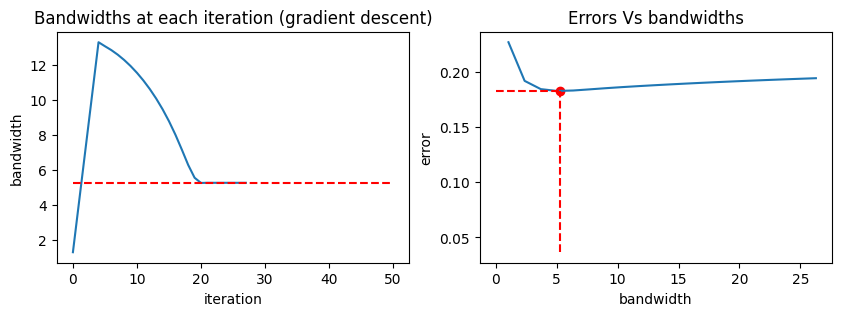

In [65]:
agg2.plot_learning_curve()

In [66]:
y_pred2 = agg2.predict(X_test2)
print(mean_absolute_percentage_error(y_test2, y_pred2))
print(mean_squared_error(y_test2, y_pred2))

0.13237641652785714
0.12259725735745385


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


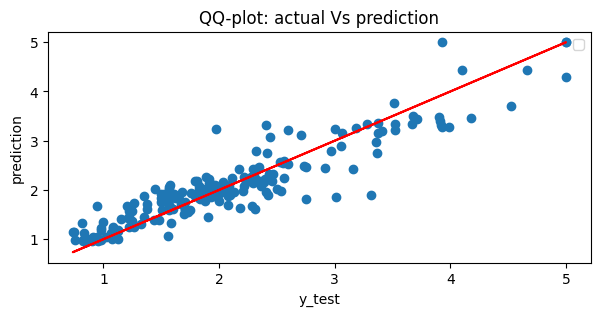

In [67]:
agg2.plot_learning_curve(y_test=y_test2, fig_type='qq')

## Compare to Random forest 

In [68]:
rf = RandomForestRegressor(n_estimators=300)
rf.fit(X_train2, y_train2)

RandomForestRegressor(n_estimators=300)

In [69]:
rf_pred = rf.predict(X_test2)
mean_absolute_percentage_error(y_test2, rf_pred)

0.12507586312062022

Text(0, 0.5, 'prediction')

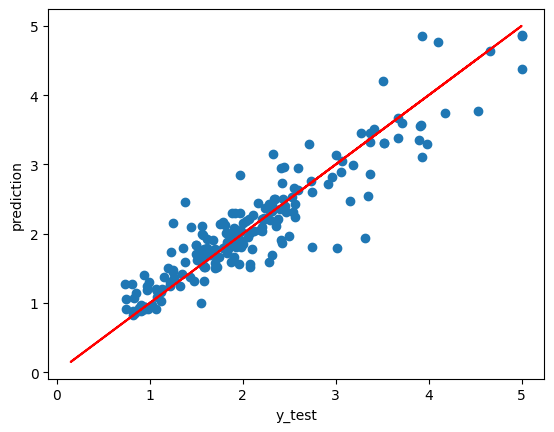

In [70]:
plt.clf()

plt.scatter(y_test2, rf_pred)
plt.plot(y_test, y_test, c = 'red')
plt.xlabel('y_test')
plt.ylabel('prediction')